In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
fpath = "../../data/DNN_data/v1/"

sig_with_artifact = np.load(fpath + "data_signal_with_square" + ".npy")
sig = np.load(fpath + "data_signal" + ".npy")
artifact = sig_with_artifact - sig

print(sig_with_artifact.shape)
print(sig.shape)

(1000, 4000)
(1000, 4000)


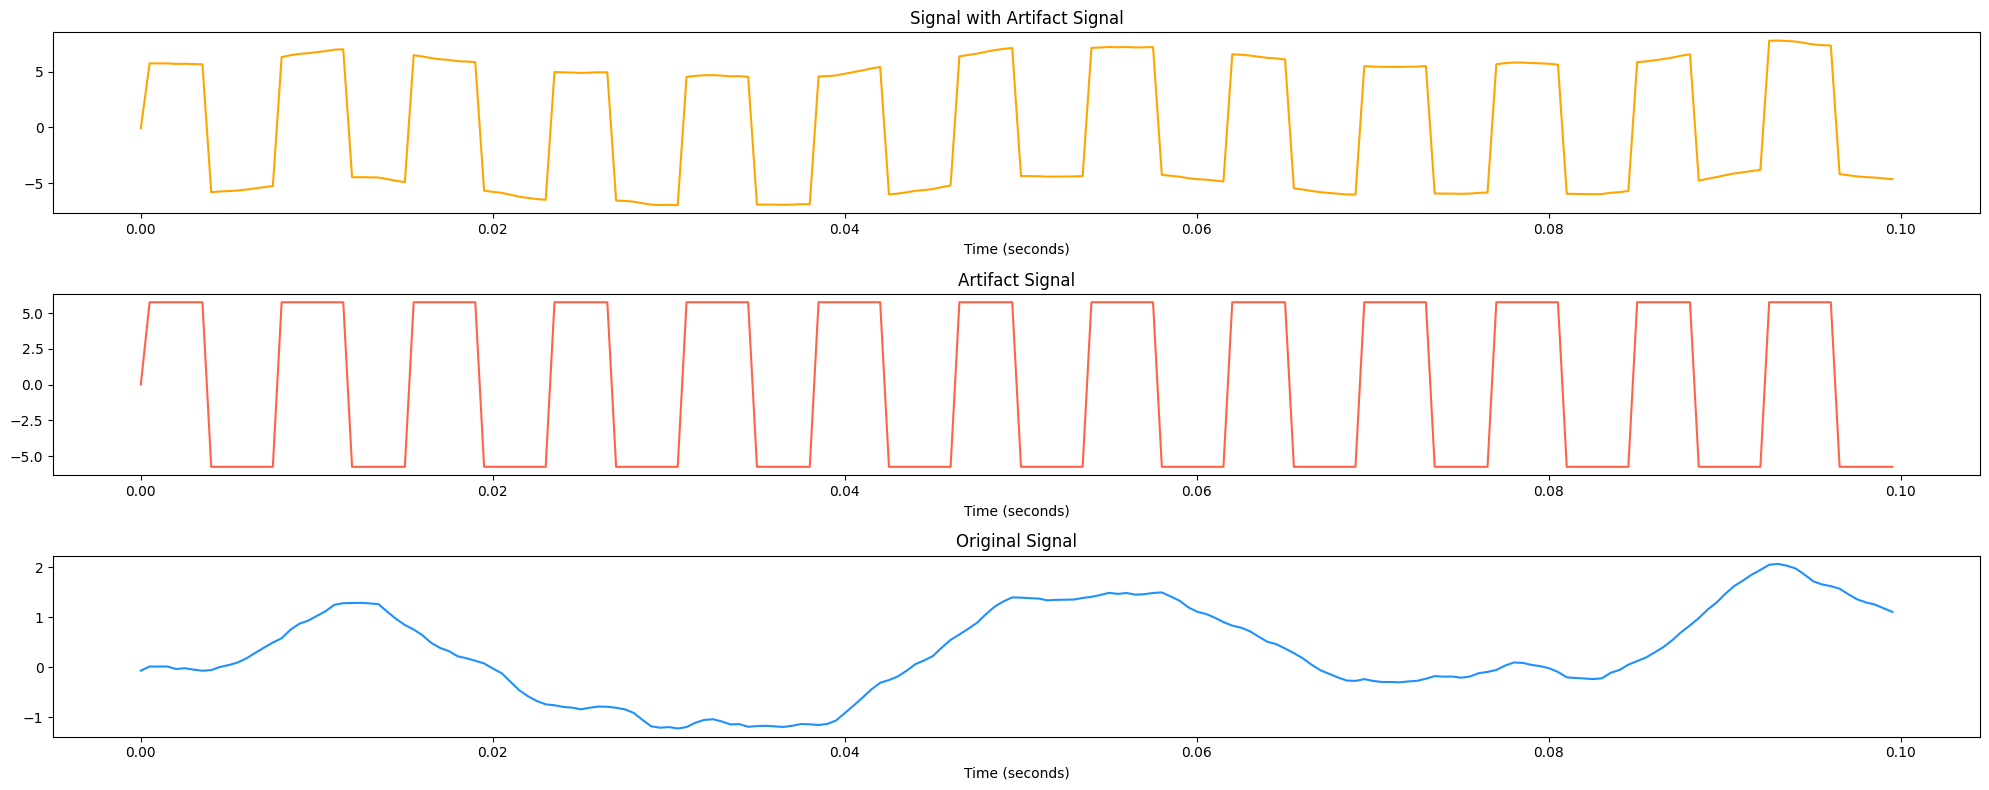

In [3]:
t = np.linspace(0, 2, num=4000) 

plt.figure(figsize=(20,8))
plt.subplot(3, 1, 1)
plt.plot(t[:200], sig_with_artifact[0][:200], color='orange')
plt.xlabel("Time (seconds)")
plt.title('Signal with Artifact Signal')

plt.subplot(3, 1, 2)
plt.plot(t[:200], artifact[0][:200], color='tomato')
plt.xlabel("Time (seconds)")
plt.title('Artifact Signal')

plt.subplot(3, 1, 3)
plt.plot(t[:200], sig[0][:200], color='dodgerblue')
plt.xlabel("Time (seconds)")
plt.title('Original Signal')

plt.tight_layout()

In [7]:
scaler = StandardScaler()

X = scaler.fit_transform(sig_with_artifact.T)
y = (sig.T-scaler.mean_)/np.sqrt(scaler.var_) # X와 동일한 평균, 표준 편차로 scaling

X = X.T
y = y.T

print(X.shape)
print(y.shape)

(1000, 4000)
(1000, 4000)


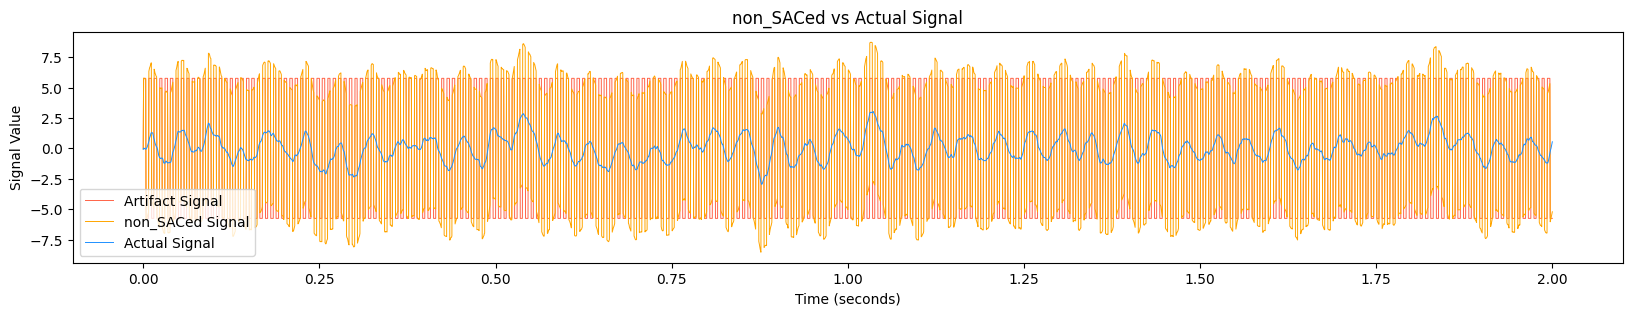

In [8]:
plt.figure(figsize=(20, 3))
plt.plot(t, artifact[0], label='Artifact Signal', color='tomato', alpha=1, linewidth=0.7)
plt.plot(t, sig_with_artifact[0], label='non_SACed Signal', color='orange', alpha=1, linewidth=0.7)
plt.plot(t, sig[0], label='Actual Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('non_SACed vs Actual Signal')
plt.legend()
plt.show()

In [9]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape: {}\ny_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x T, y : B x T
print("X_test shape: {}\ny_test shape: {}".format(X_test.shape, y_test.shape))

X_train = X_train.reshape(X_train.shape[0], 4000, 1)
X_test = X_test.reshape(X_test.shape[0], 4000, 1)

print("unsqueezed X_train shape: {}\ny_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x 1 x T, y : B x T
print("unsqueezed X_test shape: {}\ny_test shape: {}".format(X_test.shape, y_test.shape))

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

X_train shape: (800, 4000)
y_train shape: (800, 4000)
X_test shape: (200, 4000)
y_test shape: (200, 4000)
unsqueezed X_train shape: (800, 4000, 1)
y_train shape: (800, 4000)
unsqueezed X_test shape: (200, 4000, 1)
y_test shape: (200, 4000)


In [10]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes # 클래스 개수
        self.num_layers = num_layers # LSTM 계층의 개수
        self.input_size = input_size # 입력 크기로 훈련 데이터셋의 칼럼 개수를 의미
        self.hidden_size = hidden_size # hidden layer의 뉴런 개수

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) # LSTM 계층
        self.fc1 =  nn.Linear(hidden_size, 128) # 완전연결층
        self.fc2 = nn.Linear(128, num_classes) # 출력층

        self.gelu = nn.GELU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 셀 상태를 0으로 초기화
    
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        output = output.reshape(-1, self.hidden_size) # fc layer 적용을 위해 데이터를 1차원 형태로 조정
        out = self.gelu(output)
        out = self.fc_1(out)
        out = self.gelu(out)
        out = self.fc(out)
        return out

In [11]:
# 모델 인스턴스 생성
input_size = 1  # 입력 크기
hidden_size = 16  # 임의의 hidden layer 크기
num_layers = 2  # 임의의 LSTM layer 개수
num_classes = 1  # 출력 크기

model = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)
print(model)

LSTM(
  (lstm): LSTM(1, 16, num_layers=2, batch_first=True)
  (fc_1): Linear(in_features=16, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


In [12]:
# 손실 함수와 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 훈련
num_epochs = 50

for epoch in range(num_epochs):
    for batch in train_loader:   
        x = batch[0]
        y = batch[1]
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x) # y_pred : B x T
        loss = criterion(y_pred, y.view(-1, 1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1)%5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 5/50, Loss: 0.009473390877246857
Epoch 10/50, Loss: 0.0026626642793416977
Epoch 15/50, Loss: 0.001243283273652196
Epoch 20/50, Loss: 0.0009038822026923299
Epoch 25/50, Loss: 0.0006830536876805127
Epoch 30/50, Loss: 0.000586704583838582
Epoch 35/50, Loss: 0.0004876069142483175
Epoch 40/50, Loss: 0.0004257417458575219
Epoch 45/50, Loss: 0.0004358472360763699
Epoch 50/50, Loss: 0.0004390348622109741


In [13]:
# 모델 평가
non_SACed = torch.tensor([])
gt = torch.tensor([])
pred = torch.tensor([])

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x = batch[0] # x : B x T x 1
        y = batch[1] # y : B x T
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x) # y_pred : B x T

        non_SACed = torch.cat((non_SACed, x.squeeze().cpu()), 0)
        pred = torch.cat((pred, y_pred.cpu().view(-1, 4000)), 0)
        gt = torch.cat((gt, y.cpu()), 0)

val_loss = criterion(gt, pred)
print(f'Validation Loss: {val_loss.item()}')    

Validation Loss: 0.0004471507272683084


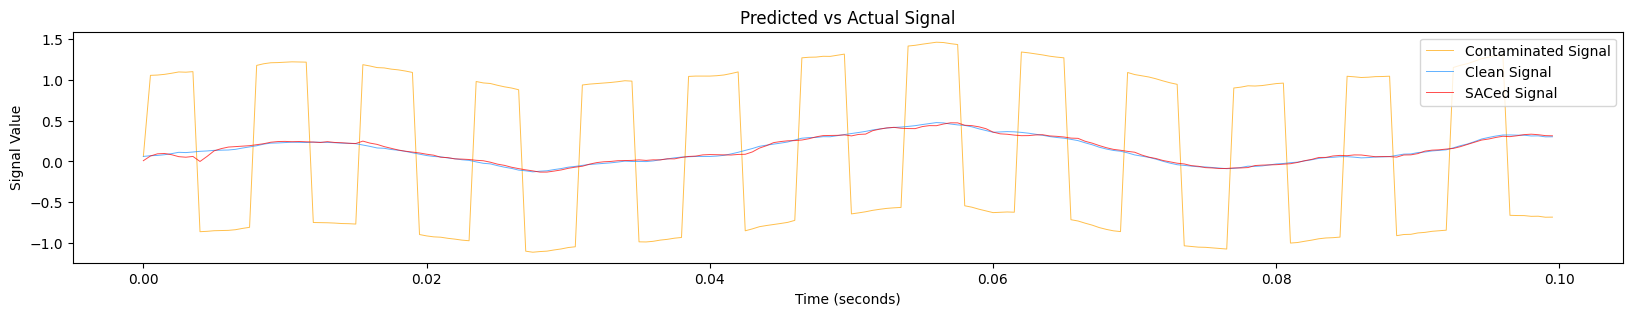

Mean Absolute Error: 0.015819499269127846
Mean Squared Error: 0.00042490792111493647


In [17]:
# time domain plotting
non_SACed_signal = non_SACed[5]
predicted_signal = pred[5]
actual_signal = gt[5]  

plt.figure(figsize=(20, 3))
plt.plot(t[:200], non_SACed_signal[:200], label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(t[:200], actual_signal[:200], label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(t[:200], predicted_signal[:200], label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('Predicted vs Actual Signal')
plt.legend()
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(actual_signal, predicted_signal)}")
print(f"Mean Squared Error: {mean_squared_error(actual_signal, predicted_signal)}")

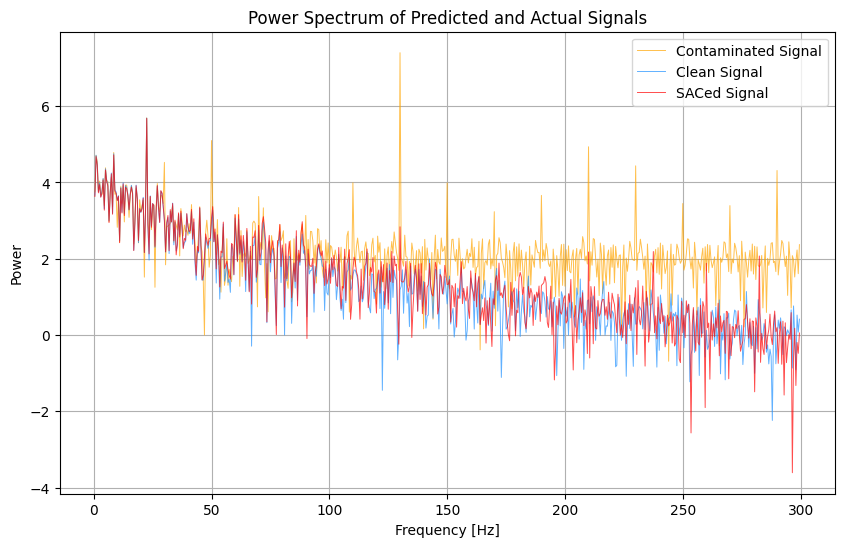

Mean Absolute Error: 0.5567552694318282
Mean Squared Error: 0.5853521907650775


In [24]:
# frequency domain plotting

n = len(predicted_signal)

fs = 2000
freqs = np.fft.fftfreq(n, d=1/fs)[:n//2]

fft_predicted = np.fft.fft(predicted_signal)
fft_predicted = np.abs(fft_predicted[:n//2])
fft_predicted[1:] = 2 * fft_predicted[1:]
power_predicted = fft_predicted**2

fft_actual = np.fft.fft(actual_signal)
fft_actual = np.abs(fft_actual[:n//2])
fft_actual[1:] = 2 * fft_actual[1:]
power_actual = fft_actual**2

fft_nonSACed = np.fft.fft(non_SACed_signal)
fft_nonSACed = np.abs(fft_nonSACed[:n//2])
fft_nonSACed[1:] = 2 * fft_nonSACed[1:]
power_nonSACed = fft_nonSACed**2

# 결과 플로팅
plt.figure(figsize=(10, 6))
plt.plot(freqs[1:600], np.log10(power_nonSACed)[1:600], label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(freqs[1:600], np.log10(power_actual)[1:600], label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(freqs[1:600], np.log10(power_predicted)[1:600], label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.title('Power Spectrum of Predicted and Actual Signals')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(np.log10(power_predicted), np.log10(power_actual))}")
print(f"Mean Squared Error: {mean_squared_error(np.log10(power_predicted), np.log10(power_actual))}")